In [1]:
# All needed imports here

import torch
from torch import nn
from torchvision.datasets import ImageFolder
from torchvision import transforms, models
from matplotlib import pyplot as plt
import torch.optim
import pandas as pd
import numpy as np
from PIL import Image

In [2]:
# Are we using cuda here?

torch.cuda.is_available()

True

In [3]:
# Load training and validation data

normalize   = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])
unnormalize = transforms.Normalize(mean=-np.array(normalize.mean) * (1/np.array(normalize.std)),
                                   std=1/np.array(normalize.std))

training_transformation = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    normalize
])

eval_transformation = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    normalize
])

train_loader = torch.utils.data.DataLoader(
    ImageFolder('data/train_cleaned/',transform=training_transformation),
    batch_size=16,
    shuffle=True)

valid_loader = torch.utils.data.DataLoader(
    ImageFolder('data/valid_cleaned/',transform=eval_transformation),
    batch_size=16,
    shuffle=False)

class_to_idx = train_loader.dataset.class_to_idx
idx_to_class = {idx:cls for cls,idx in class_to_idx.items()}

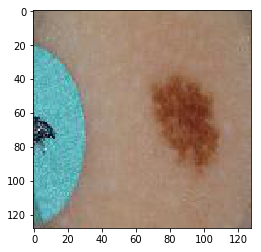

nevus


In [35]:
# Look at some training data

img_batch_tensor,batch_labels = next(iter(train_loader))
plt.imshow(unnormalize(img_batch_tensor[0]).permute(1,2,0))
plt.show()
print(idx_to_class[batch_labels[0].item()])

In [5]:
derm_net = models.vgg16_bn(pretrained=True)

In [6]:
# for param in derm_net.features.parameters(): param.requires_grad = False

In [7]:
# del derm_net.classifier._modules['6']
# del derm_net.classifier._modules['5']
# del derm_net.classifier._modules['4']
# del derm_net.classifier._modules['3']
# del derm_net.classifier._modules['2']
# del derm_net.classifier._modules['0']

In [8]:
# derm_net.classifier.add_module('0',torch.nn.Linear(2048,1024))
# derm_net.classifier.add_module('2',torch.nn.BatchNorm1d(1024))
# derm_net.classifier.add_module('3',torch.nn.Linear(1024,3))
# derm_net.classifier.add_module('4',torch.nn.LogSoftmax(dim=1))
# derm_net

derm_net.classifier = torch.nn.Sequential(torch.nn.Linear(8192,1024),
                                          torch.nn.ReLU(),
                                          torch.nn.BatchNorm1d(1024),
                                          torch.nn.Linear(1024,3),
                                          torch.nn.LogSoftmax(dim=1),
                                         )

derm_net

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

In [9]:
from timeit import default_timer as timer
from datetime import timedelta
import numpy as np
import sys

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    num_train_imgs=len(loaders['train'])*loaders['train'].batch_size
    num_valid_imgs=len(loaders['valid'])*loaders['valid'].batch_size
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        start_time = timer()
        
        start_batch_load = timer()
        
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            time_to_load_batch = timer()-start_batch_load
            optimizer.zero_grad()
            loss=criterion(model(data),target)
            loss.backward()
            optimizer.step()
            train_loss += ((1 / (batch_idx + 1)) * (loss.item() - train_loss)) #this is clever!
            sys.stdout.write("Processed "+str(batch_idx*loaders['train'].batch_size)+'/'+str(num_train_imgs))
            
            time_to_step = timer()-start_batch_load-time_to_load_batch
            start_batch_load = timer()
            sys.stdout.write(". {:.1f}% time on loading img, {:.1f}% time on stepping \r".format(
                100*time_to_load_batch/(time_to_load_batch+time_to_step),
                100*time_to_step/(time_to_load_batch+time_to_step)
            ))
            
            sys.stdout.flush()
            
        model.eval()
        num_correct=0
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            with torch.no_grad():
                output=model(data)
                loss=criterion(output,target)
                num_correct+=torch.sum(output.argmax(1)==target).item()
                valid_loss += ((1 / (batch_idx + 1)) * (loss.item() - valid_loss))
            sys.stdout.write("Processed "+str(batch_idx*loaders['valid'].batch_size)+'/'+str(num_valid_imgs)+'     \r')
            sys.stdout.flush()

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}\t Validation Acc: {:.2f}'.format(
            epoch, 
            train_loss,
            valid_loss,
            100*num_correct/float(num_valid_imgs)
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss<valid_loss_min:
            torch.save(model.state_dict(),save_path)
            valid_loss_min=valid_loss
            
        epoch_time = timer() - start_time
        print(f'That took {timedelta(seconds=epoch_time)}.\
              Estimated time remaining: {timedelta(seconds=epoch_time*(n_epochs-epoch))}\n')
            
    # return trained model
    return model

In [10]:
if torch.cuda.is_available(): derm_net = derm_net.cuda()

derm_net = train(n_epochs=4,
                 loaders={'train':train_loader,'valid':valid_loader},
                 model=derm_net,
                 optimizer=torch.optim.SGD(derm_net.parameters(),lr=0.01,momentum=0.5),
                 criterion=torch.nn.NLLLoss(),
                 use_cuda=torch.cuda.is_available(),
                 save_path='derm_net.pt')

Epoch: 1 	Training Loss: 0.848295 	Validation Loss: 0.795882	 Validation Acc: 63.75
That took 0:00:26.422164.              Estimated time remaining: 0:01:19.266491

Epoch: 2 	Training Loss: 0.516035 	Validation Loss: 0.824449	 Validation Acc: 60.00
That took 0:00:25.239870.              Estimated time remaining: 0:00:50.479740

Epoch: 3 	Training Loss: 0.289987 	Validation Loss: 0.846052	 Validation Acc: 65.00 loading img, 93.8% time on stepping 
That took 0:00:26.236498.              Estimated time remaining: 0:00:26.236498

Epoch: 4 	Training Loss: 0.145791 	Validation Loss: 0.995785	 Validation Acc: 63.12
That took 0:00:25.696669.              Estimated time remaining: 0:00:00



In [56]:
derm_net.eval()
ids=pd.read_csv('sample_predictions.csv')['Id']
test_results=pd.DataFrame(ids)
def id_to_predictions(filename):
    img = eval_transformation(Image.open(filename).convert('RGB')).unsqueeze(dim=0)
    if torch.cuda.is_available(): img = img.cuda()
    with torch.no_grad():
        output = torch.exp(derm_net( img ))
    prob0_item,_,prob2_item = output.cpu().numpy()[0]
    return prob0_item,prob2_item
test_results["task_1"],test_results["task_2"] = zip(*ids.map(id_to_predictions))
test_results.head()

,Id,task_1,task_2
0,data/test/melanoma/ISIC_0012258.jpg,0.115233,0.034199
1,data/test/melanoma/ISIC_0012356.jpg,0.050086,0.010667
2,data/test/melanoma/ISIC_0012369.jpg,0.218324,0.004036
3,data/test/melanoma/ISIC_0012395.jpg,0.015997,0.003320
4,data/test/melanoma/ISIC_0012425.jpg,0.004812,0.002732


In [58]:
test_results.to_csv('test_results.csv')